# EDA on CNN Embeddings and Subject Aggregation

**Project**: Parkinson's Disease Detection
**Purpose**: Exploratory Data Analysis (EDA) on CNN-extracted embeddings and subject-level aggregated embeddings.
**Note**: This notebook reads existing output files and does not modify any source code or input data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
import os

try:
    import umap
except ImportError:
    umap = None

# Set random seeds
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Define paths
# Using relative paths for local execution as /mnt/data does not exist
# Notebook is in notebooks/, so outputs are in ../outputs
OUT = "../outputs" 
PLOTS_DIR = os.path.join(OUT, "plots", "eda")

os.makedirs(PLOTS_DIR, exist_ok=True)
print(f"Outputs directory: {OUT}")
print(f"Plots directory: {PLOTS_DIR}")


Outputs directory: ../outputs
Plots directory: ../outputs/plots/eda


In [2]:
# Load data files
embeddings_path = os.path.join(OUT, "embeddings.npy")
manifest_path = os.path.join(OUT, "manifest.csv")
embeddings_subjects_path = os.path.join(OUT, "embeddings_subjects.npy")
subjects_manifest_path = os.path.join(OUT, "subjects_manifest.csv")

embeddings = np.load(embeddings_path)
manifest = pd.read_csv(manifest_path)
embeddings_subjects = np.load(embeddings_subjects_path)
subjects_manifest = pd.read_csv(subjects_manifest_path)

print("Shapes:")
print(f"Embeddings (Image-level): {embeddings.shape}")
print(f"Manifest (Image-level): {manifest.shape}")
print(f"Embeddings (Subject-level): {embeddings_subjects.shape}")
print(f"Manifest (Subject-level): {subjects_manifest.shape}")

print("\nImage Manifest Head:")
display(manifest.head())

print("\nSubject Manifest Head:")
display(subjects_manifest.head())

print(f"\nNumber of images: {len(manifest)}")
print(f"Number of subjects: {len(subjects_manifest)}")
print(f"Embedding dimensions: {embeddings.shape[1]}")


Shapes:
Embeddings (Image-level): (44007, 512)
Manifest (Image-level): (44007, 3)
Embeddings (Subject-level): (78, 512)
Manifest (Subject-level): (78, 2)

Image Manifest Head:


,image_path,subject_alias,label
0,data/ntua-parkinson-dataset-master/PD/Subject4...,Subject46,1
1,data/ntua-parkinson-dataset-master/PD/Subject4...,Subject46,1
2,data/ntua-parkinson-dataset-master/PD/Subject4...,Subject46,1
3,data/ntua-parkinson-dataset-master/PD/Subject4...,Subject46,1
4,data/ntua-parkinson-dataset-master/PD/Subject4...,Subject46,1



Subject Manifest Head:


,subject_alias,label
0,Subject46,1
1,Subject41,1
2,Subject77,1
3,Subject48,1
4,Subject70,1



Number of images: 44007
Number of subjects: 78
Embedding dimensions: 512


Missing values in Image Manifest:
image_path       0
subject_alias    0
label            0
dtype: int64

Missing values in Subject Manifest:
subject_alias    0
label            0
dtype: int64

Unique subjects in image manifest: 78
Unique subjects in subject manifest: 78

Images per subject stats:
count      78.000000
mean      564.192308
std       535.833301
min         1.000000
25%       215.250000
50%       393.000000
75%       764.750000
max      3124.000000
dtype: float64

Label distribution (Image-level):
label
1    33296
0    10711
Name: count, dtype: int64

Label distribution (Subject-level):
label
1    55
0    23
Name: count, dtype: int64


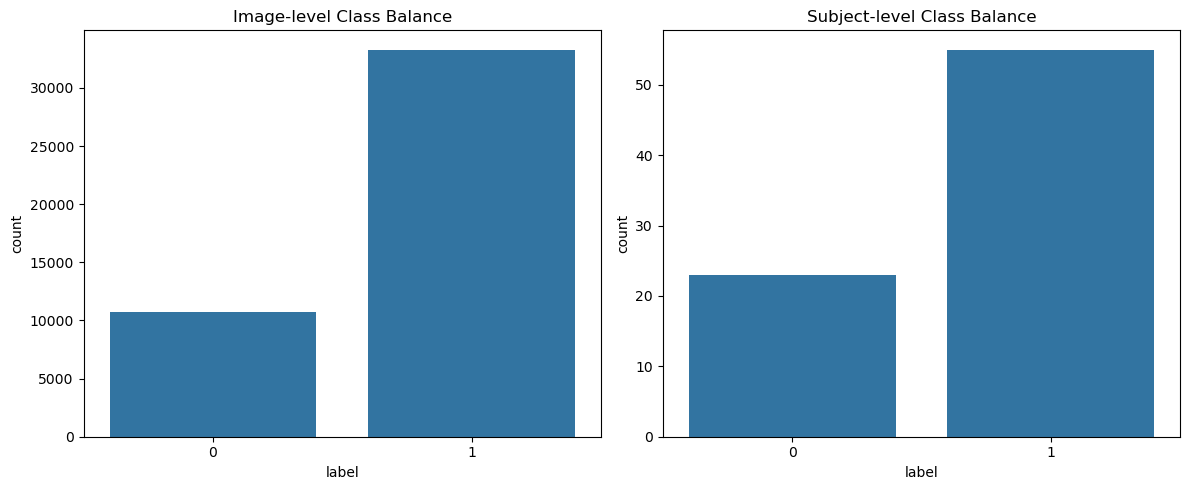

In [3]:
# Sanity Checks
print("Missing values in Image Manifest:")
print(manifest.isnull().sum())
print("\nMissing values in Subject Manifest:")
print(subjects_manifest.isnull().sum())

# Check unique subjects
unique_subjects_img = manifest['subject_alias'].nunique()
unique_subjects_sub = subjects_manifest['subject_alias'].nunique()
print(f"\nUnique subjects in image manifest: {unique_subjects_img}")
print(f"Unique subjects in subject manifest: {unique_subjects_sub}")
assert unique_subjects_img == unique_subjects_sub, "Mismatch in subject counts!"

# Images per subject distribution
img_per_sub = manifest.groupby('subject_alias').size()
print("\nImages per subject stats:")
print(img_per_sub.describe())

# Save small table
img_per_sub_df = img_per_sub.reset_index(name='image_count')
# display(img_per_sub_df.head())

# Label distribution
print("\nLabel distribution (Image-level):")
print(manifest['label'].value_counts())
print("\nLabel distribution (Subject-level):")
print(subjects_manifest['label'].value_counts())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=manifest, x='label', ax=axes[0])
axes[0].set_title("Image-level Class Balance")
sns.countplot(data=subjects_manifest, x='label', ax=axes[1])
axes[1].set_title("Subject-level Class Balance")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "class_balance.png"))
plt.show()

# Save summary CSV
label_summary = pd.DataFrame({
    'image_level': manifest['label'].value_counts(),
    'subject_level': subjects_manifest['label'].value_counts()
})
label_summary.to_csv(os.path.join(PLOTS_DIR, "label_distribution_summary.csv"))


Top 10 dimensions by variance:
               mean       std      min        max
dimension                                        
273        3.646386  1.446437  0.00027  10.255974
145        1.957934  1.420249  0.00000  11.552428
232        2.153661  1.341312  0.00000   7.675572
215        2.556518  1.296725  0.00000   8.250180
268        4.388687  1.260446  0.01177  10.654316
248        2.332746  1.229874  0.00000   8.227853
96         2.570213  1.220377  0.00000   8.558125
421        1.278296  1.216410  0.00000   8.682061
136        1.651112  1.207585  0.00000   6.652387
151        1.327495  1.147406  0.00000   7.749001


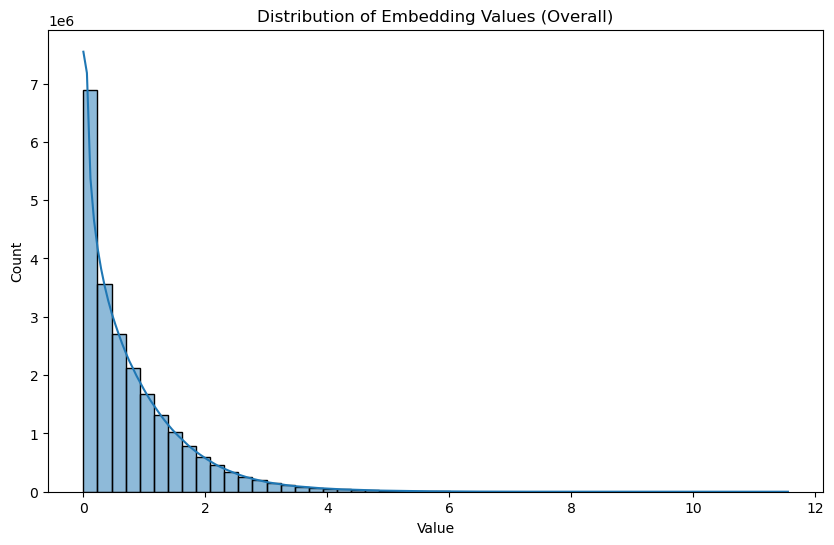

In [4]:
# Summary statistics of embeddings (Image-level)
# Calculate per-dimension stats
mean_emb = np.mean(embeddings, axis=0)
std_emb = np.std(embeddings, axis=0)
min_emb = np.min(embeddings, axis=0)
max_emb = np.max(embeddings, axis=0)

stats_df = pd.DataFrame({
    'mean': mean_emb,
    'std': std_emb,
    'min': min_emb,
    'max': max_emb
})
stats_df.index.name = 'dimension'

# Top 10 dims by variance
top_10_var_idx = np.argsort(std_emb**2)[::-1][:10]
print("Top 10 dimensions by variance:")
print(stats_df.iloc[top_10_var_idx])

stats_df.to_csv(os.path.join(PLOTS_DIR, "embedding_feature_stats.csv"))

# Histogram of all embedding values
plt.figure(figsize=(10, 6))
sns.histplot(embeddings.flatten(), bins=50, kde=True)
plt.title("Distribution of Embedding Values (Overall)")
plt.xlabel("Value")
plt.ylabel("Count")
plt.savefig(os.path.join(PLOTS_DIR, "embedding_values_histogram.png"))
plt.show()


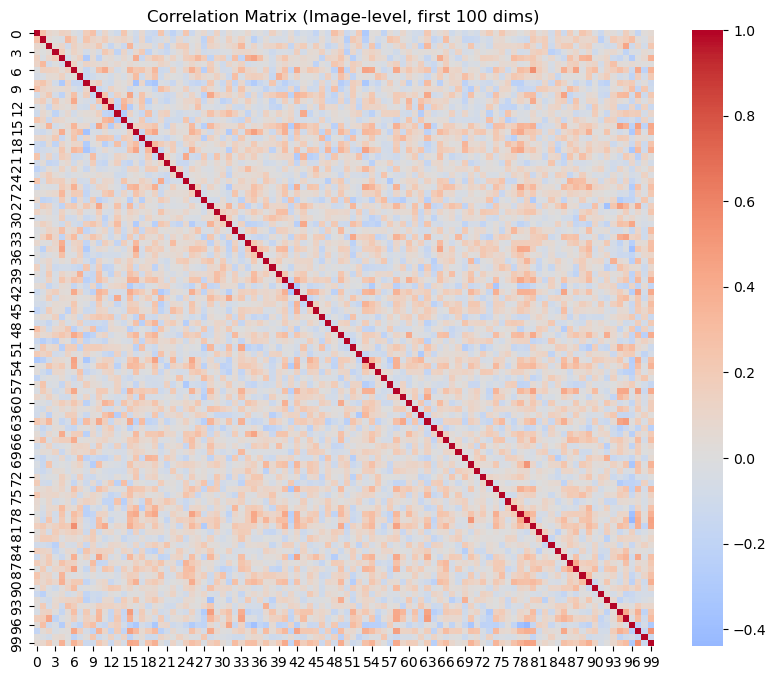

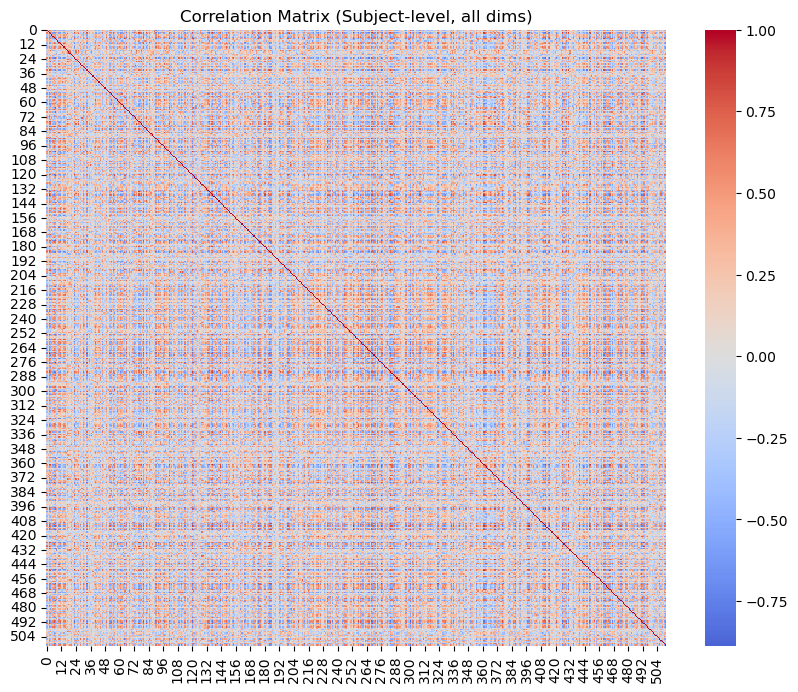

In [5]:
# Feature correlations
# Image-level (first 100 dims)
n_dims_corr = min(100, embeddings.shape[1])
corr_img = np.corrcoef(embeddings[:, :n_dims_corr], rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_img, cmap='coolwarm', center=0)
plt.title(f"Correlation Matrix (Image-level, first {n_dims_corr} dims)")
plt.savefig(os.path.join(PLOTS_DIR, "correlation_image_level.png"))
plt.show()

# Subject-level (all dims)
corr_sub = np.corrcoef(embeddings_subjects, rowvar=False)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_sub, cmap='coolwarm', center=0)
plt.title("Correlation Matrix (Subject-level, all dims)")
plt.savefig(os.path.join(PLOTS_DIR, "correlation_subject_level.png"))
plt.show()


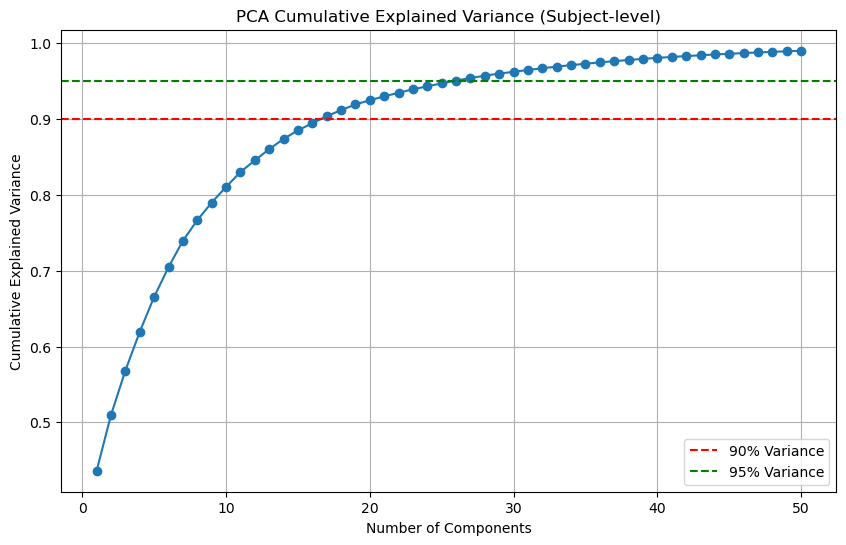

Components for 90% variance: 17
Components for 95% variance: 26


In [6]:
# PCA Explained Variance (Subject-level)
n_components = min(50, embeddings_subjects.shape[1])
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
pca.fit(embeddings_subjects)

cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cum_var, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance (Subject-level)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(PLOTS_DIR, "pca_variance_eda.png"))
plt.show()

n_90 = np.argmax(cum_var >= 0.90) + 1
n_95 = np.argmax(cum_var >= 0.95) + 1
print(f"Components for 90% variance: {n_90}")
print(f"Components for 95% variance: {n_95}")


UMAP not available, using t-SNE...


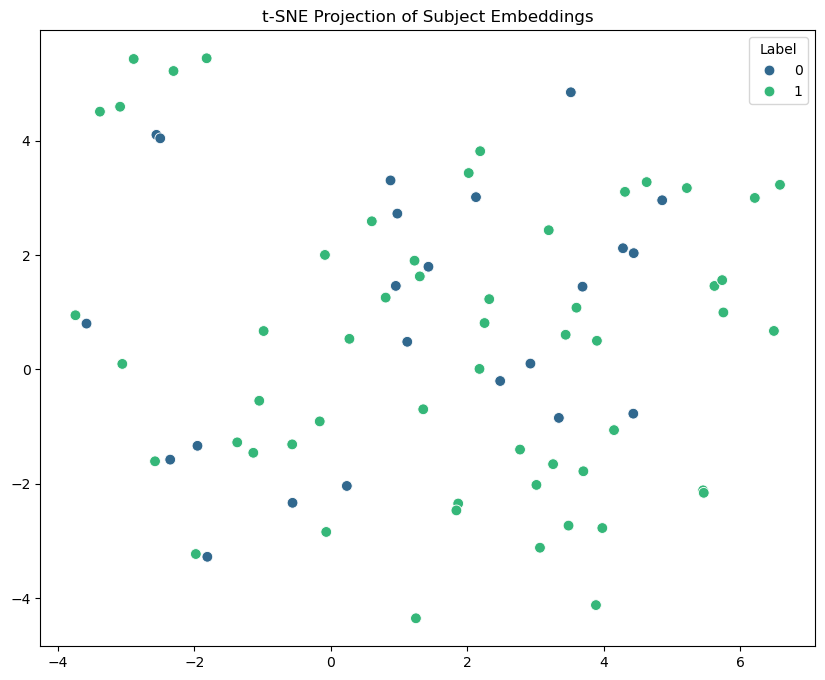

In [7]:
# t-SNE / UMAP Visualization
labels = subjects_manifest['label'].values
# Sample if too many subjects
if len(subjects_manifest) > 1000:
    print("Sampling 1000 subjects for visualization...")
    idx = np.random.choice(len(subjects_manifest), 1000, replace=False)
    X_viz = embeddings_subjects[idx]
    y_viz = labels[idx]
else:
    X_viz = embeddings_subjects
    y_viz = labels

if umap is not None:
    print("Using UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
    embedding_viz = reducer.fit_transform(X_viz)
    title = "UMAP Projection of Subject Embeddings"
    fname = "umap_subjects.png"
else:
    print("UMAP not available, using t-SNE...")
    perplexity = 30 if len(X_viz) > 30 else max(5, len(X_viz) // 2)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_STATE)
    embedding_viz = tsne.fit_transform(X_viz)
    title = "t-SNE Projection of Subject Embeddings"
    fname = "tsne_subjects.png"

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding_viz[:, 0], y=embedding_viz[:, 1], hue=y_viz, palette='viridis', s=60)
plt.title(title)
plt.legend(title='Label')
plt.savefig(os.path.join(PLOTS_DIR, fname))
plt.show()


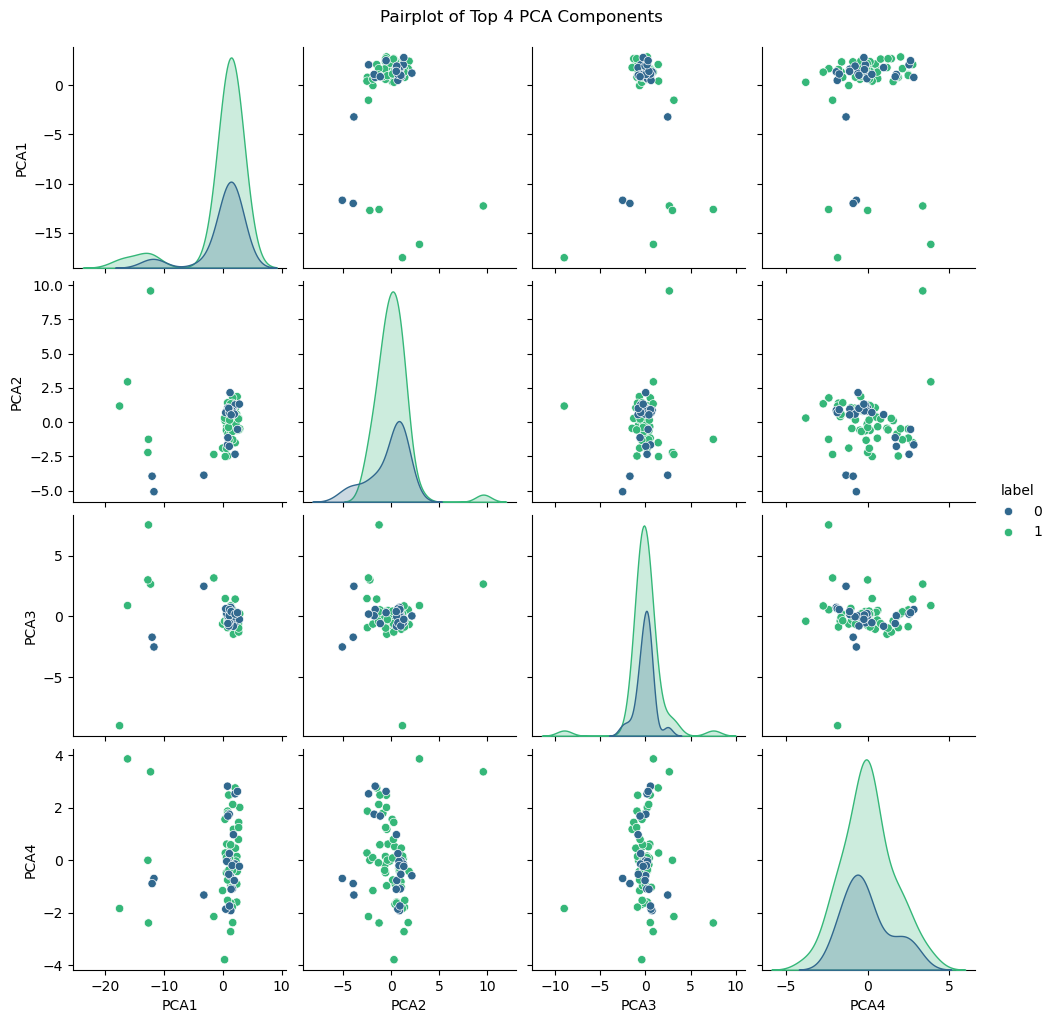

In [8]:
# Pairplot of top 4 PCA components
pca_4 = PCA(n_components=4, random_state=RANDOM_STATE)
X_pca_4 = pca_4.fit_transform(embeddings_subjects)

df_pca = pd.DataFrame(X_pca_4, columns=[f'PCA{i+1}' for i in range(4)])
df_pca['label'] = subjects_manifest['label'].values

if len(df_pca) > 500:
    print("Sampling 500 subjects for pairplot...")
    df_pca_sample = df_pca.sample(n=500, random_state=RANDOM_STATE)
else:
    df_pca_sample = df_pca

sns.pairplot(df_pca_sample, hue='label', palette='viridis')
plt.suptitle("Pairplot of Top 4 PCA Components", y=1.02)
plt.savefig(os.path.join(PLOTS_DIR, "pairplot_pca4.png"))
plt.show()


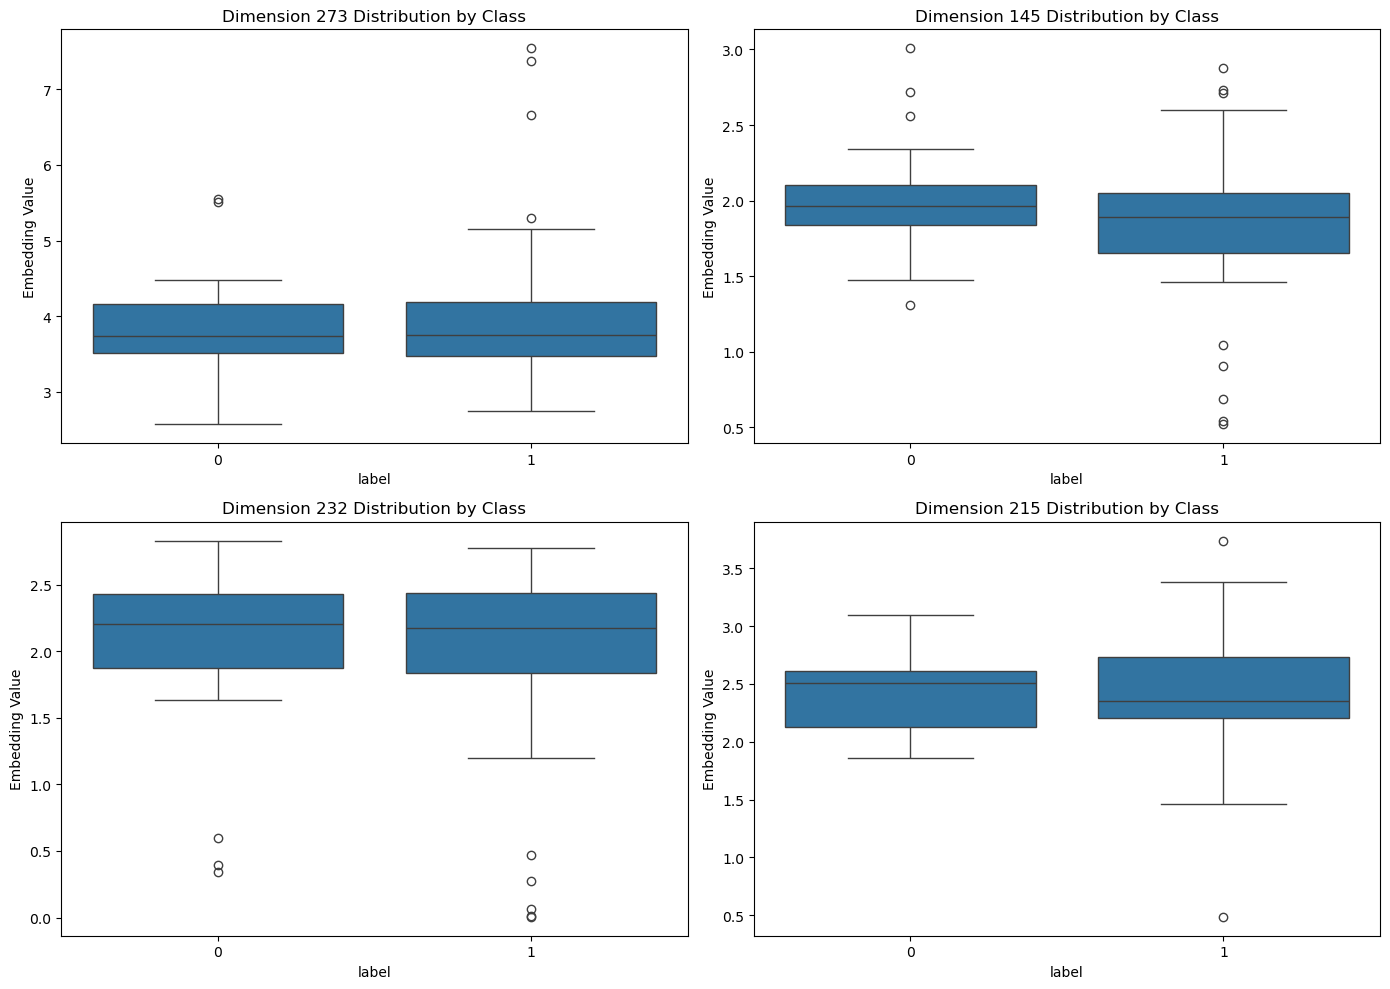

In [9]:
# Per-class embedding distributions (Top 4 dims by variance)
# We already calculated top dims by variance in stats_df
top_4_dims = top_10_var_idx[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, dim_idx in enumerate(top_4_dims):
    sns.boxplot(x=subjects_manifest['label'], y=embeddings_subjects[:, dim_idx], ax=axes[i])
    axes[i].set_title(f"Dimension {dim_idx} Distribution by Class")
    axes[i].set_ylabel("Embedding Value")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "boxplots_top_dims.png"))
plt.show()


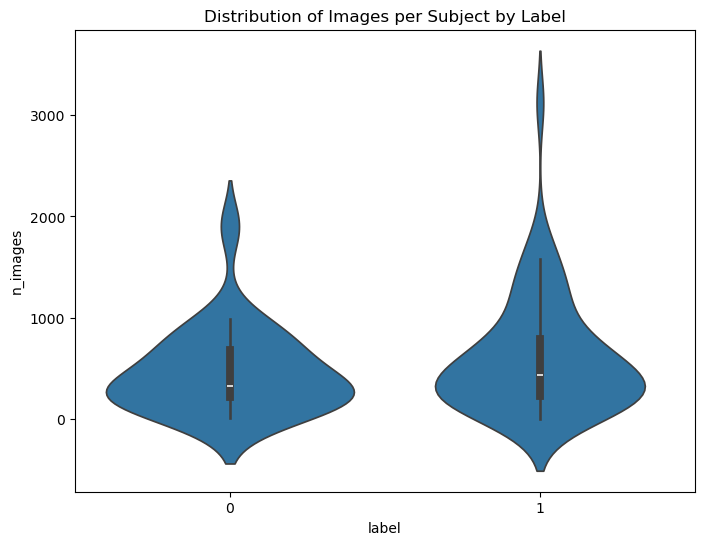

In [10]:
# Image-level analysis: Images per subject vs Label
img_counts = manifest.groupby('subject_alias').size().reset_index(name='n_images')
# Merge with label
img_counts = img_counts.merge(subjects_manifest[['subject_alias', 'label']], on='subject_alias')

plt.figure(figsize=(8, 6))
sns.violinplot(x='label', y='n_images', data=img_counts)
plt.title("Distribution of Images per Subject by Label")
plt.savefig(os.path.join(PLOTS_DIR, "images_per_subject.png"))
plt.show()


In [11]:
# Clustering Quality (Silhouette Score)
from sklearn.metrics import silhouette_score

# Using the PCA-reduced data (4 components) from earlier
score = silhouette_score(X_pca_4, subjects_manifest['label'])
print(f"Silhouette Score (k=2, PCA=4): {score:.4f}")

if score > 0.5:
    print("Clusters align well with labels.")
elif score > 0.2:
    print("Some separation, but significant overlap.")
else:
    print("Poor separation between classes.")


Silhouette Score (k=2, PCA=4): -0.0297
Poor separation between classes.


In [12]:
# Save summary CSV
summary_df = subjects_manifest[['subject_alias', 'label']].copy()
summary_df['n_images'] = img_counts['n_images'] # Assuming order is preserved or merge needed
# Better to merge to be safe
summary_df = subjects_manifest[['subject_alias', 'label']].merge(img_counts[['subject_alias', 'n_images']], on='subject_alias')

# Add first 4 embedding dims
for i in range(4):
    summary_df[f'mean_embedding_{i}'] = embeddings_subjects[:, i]

# Add PCA scores
for i in range(4):
    summary_df[f'PCA{i+1}'] = X_pca_4[:, i]

summary_df.to_csv(os.path.join(PLOTS_DIR, "summary_statistics_subjects.csv"), index=False)
print("Saved summary_statistics_subjects.csv")


Saved summary_statistics_subjects.csv


# Conclusions

*   **Label Balance**: [To be filled after execution]
*   **Embedding Scale**: [To be filled after execution]
*   **PCA Variance**: [To be filled after execution]
*   **Visualization Insights**: [To be filled after execution]
*   **Next Steps**: Normalize features, try fine-tuning CNN, treat class imbalance if needed.
